In [8]:
import sys
import math
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sys.path.append(str(Path("..").resolve()))
from hyper_rbm import load_model


models_dir = Path("models")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")
print(f"Looking for models in: {models_dir}")

Running on: cpu
Looking for models in: models


In [2]:
def _stable_log_mean_exp(x: torch.Tensor) -> torch.Tensor:
    m = torch.max(x)
    return (torch.log(torch.sum(torch.exp(x - m))) + m) - math.log(x.numel())


def compute_renyi_entropy(samples: torch.Tensor, subs_size: int, log_score_fn: callable) -> float:
    n_samples = samples.shape[0]
    half = n_samples // 2
    if half == 0:
        return 0.0

    ref_1 = samples[:half]
    ref_2 = samples[half:2 * half]

    ref_1_score = log_score_fn(ref_1)
    ref_2_score = log_score_fn(ref_2)

    slice_idx = torch.arange(subs_size, samples.shape[1], device=samples.device)

    swap_1 = ref_1.clone()
    swap_1[:, slice_idx] = ref_2[:, slice_idx]
    swap_2 = ref_2.clone()
    swap_2[:, slice_idx] = ref_1[:, slice_idx]

    swap_1_score = log_score_fn(swap_1)
    swap_2_score = log_score_fn(swap_2)

    log_swap_ratio = swap_1_score + swap_2_score - ref_1_score - ref_2_score

    log_swap_exp = _stable_log_mean_exp(log_swap_ratio)
    renyi_entropy = -log_swap_exp.item()
    return renyi_entropy


def compute_renyi_entropy_batched(samples: torch.Tensor, subs_size: int,
                                  log_score_fn: callable, batch_size: int = 10_000) -> tuple:
    n_total = samples.shape[0]
    if n_total < 2:
        return float("nan"), 0.0

    s2_batches = []
    for start in range(0, n_total, batch_size):
        end = min(start + batch_size, n_total)
        if end - start < 2:
            continue

        s2 = compute_renyi_entropy(samples[start:end], subs_size, log_score_fn)
        if not np.isnan(s2):
            s2_batches.append(s2)

    vals = np.asarray(s2_batches, dtype=float)
    mean = float(np.mean(vals)) if len(vals) else float("nan")
    err = float(np.std(vals, ddof=1) / np.sqrt(len(vals))) if len(vals) > 1 else 0.0
    return mean, err # this error is probably not correct

In [3]:
model_filename = "hyprbm_tfim_16_20000_20260204_034149.pt"
model_path = models_dir / model_filename

print(f"Loading checkpoint: {model_path.name}")

model, config = load_model(model_path, device)

CHAIN_LENGTH = int(model.num_v)
h_support_vals = sorted(config.get("h_support", []))
print(f"Trained on support points: {h_support_vals} \n")

ref_file = Path(f"tfim_{CHAIN_LENGTH}_entangle_ref.csv")
ref_df = pd.read_csv(ref_file)
print(f"Loaded ED reference data from: {ref_file.name}")

Loading checkpoint: hyprbm_tfim_16_20000_20260204_034149.pt
Trained on support points: [0.5, 0.8, 0.95, 1.0, 1.05, 1.2, 1.5] 

Loaded ED reference data from: tfim_16_entangle_ref.csv


In [5]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

ANNEAL_STEPS = 100

TOTAL_SAMPLES = 300_000
BATCH_SIZE = 20_000
DENSE_RES = 0.05


h_novel_vals = np.arange(min(h_support_vals), max(h_support_vals) + 0.01, DENSE_RES)
h_novel_vals = [h for h in h_novel_vals if not any(np.isclose(h, s, atol=1e-3) for s in h_support_vals)]
all_h_values = sorted(list(set(h_support_vals) | set(h_novel_vals)))

print(f"Sweeping h on dense grid: [{min(all_h_values):.2f}, {max(all_h_values):.2f}] | step={DENSE_RES}")
print(f"TOTAL_SAMPLES={TOTAL_SAMPLES} | BATCH_SIZE={BATCH_SIZE}")

results_list = []
l_axis = list(range(1, CHAIN_LENGTH // 2 + 1))

rng_eval = torch.Generator(device=device).manual_seed(SEED)
model_dtype = next(model.parameters()).dtype

for h_val in all_h_values:
    split = "support" if any(np.isclose(h_val, s, atol=1e-3) for s in h_support_vals) else "interpolated"
    print(f"h={h_val:.2f} ({split:12})")

    cond_batch = torch.full((TOTAL_SAMPLES, 1), h_val, device=device, dtype=model_dtype)

    # use constant schedule of T=1.0 for generation
    schedule = torch.tensor([1.0] * ANNEAL_STEPS, device=device, dtype=model_dtype)
    with torch.no_grad():
        samples = model.generate(cond_batch, schedule, rng=rng_eval)

    def scorer(v):
        # prime scoring function with h_val
        c = torch.full((v.shape[0], 1), h_val, device=v.device, dtype=v.dtype)
        return model.log_score(v, c)

    for l in l_axis:
        s2_mean, s2_err = compute_renyi_entropy_batched(samples, l, scorer, batch_size=BATCH_SIZE)
        results_list.append({"h": float(h_val), "l": int(l), "s2": s2_mean, "s2_err": s2_err, "type": split})

results_df = pd.DataFrame(results_list)

Sweeping h on dense grid: [0.50, 1.50] | step=0.05
TOTAL_SAMPLES=300000 | BATCH_SIZE=20000
h=0.50 (support     )
h=0.55 (interpolated)
h=0.60 (interpolated)
h=0.65 (interpolated)
h=0.70 (interpolated)
h=0.75 (interpolated)
h=0.80 (support     )
h=0.85 (interpolated)
h=0.90 (interpolated)
h=0.95 (support     )
h=1.00 (support     )
h=1.05 (support     )
h=1.10 (interpolated)
h=1.15 (interpolated)
h=1.20 (support     )
h=1.25 (interpolated)
h=1.30 (interpolated)
h=1.35 (interpolated)
h=1.40 (interpolated)
h=1.45 (interpolated)
h=1.50 (support     )


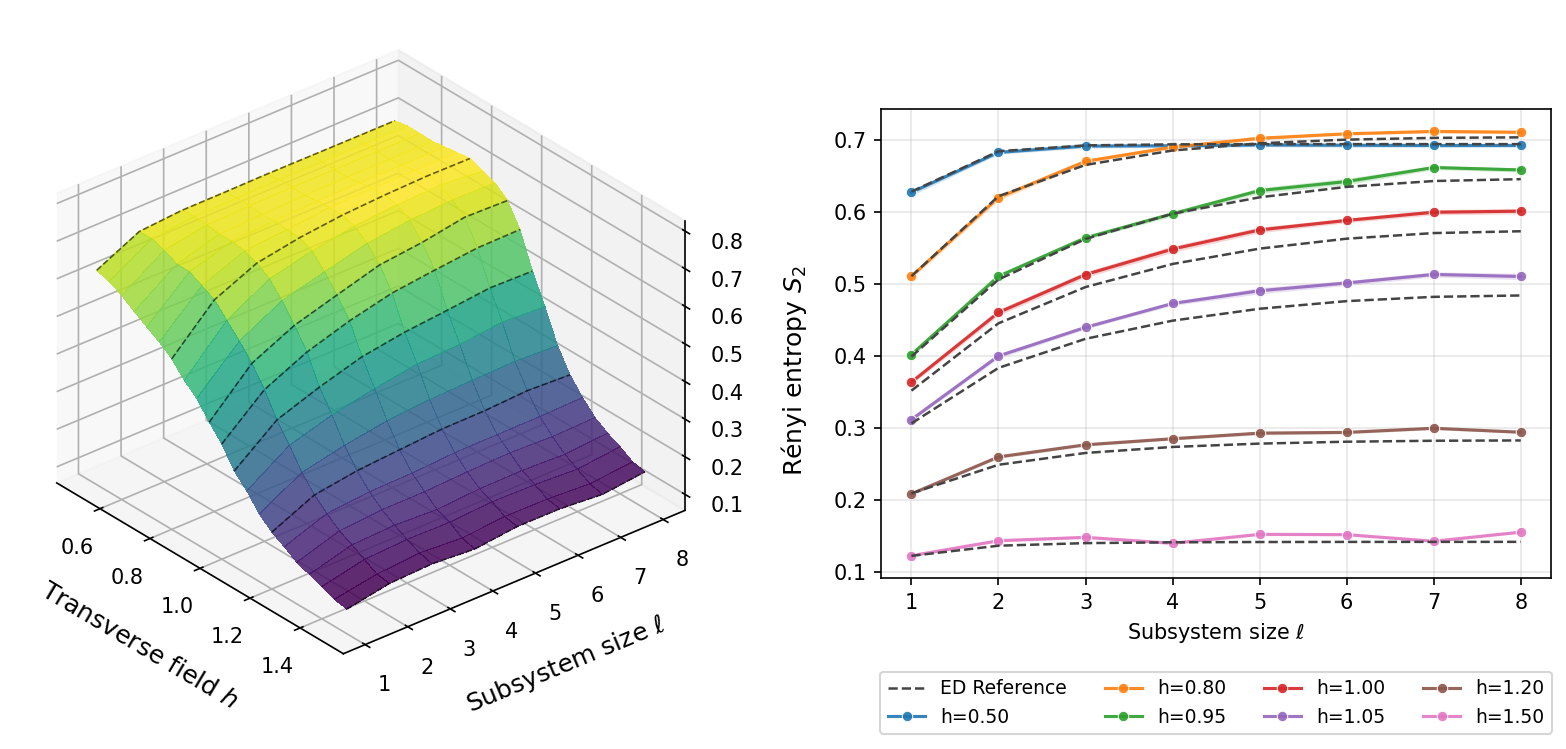

In [6]:
# CONFIGURATION (plot only)
PLOT_WSPACE = -0.15
VERTICAL_OFFSET_2D = 0.02
BOX_ASPECT_2D = 0.7
Z_LABEL_PAD = 9
TITLE_PAD_2D = 20
LEGEND_NCOL = 4
LEGEND_X = 0.5
LEGEND_Y = -0.18

MAX_SURF_COLS = 220
MAX_SURF_ROWS = 80
SURF_SHADE    = False

pivot_df = results_df.pivot(index='l', columns='h', values='s2')
pivot_df = pivot_df.sort_index().sort_index(axis=1)

h_dense  = pivot_df.columns.to_numpy(dtype=float)
l_values = pivot_df.index.to_numpy(dtype=float)

X_h, Y_l = np.meshgrid(h_dense, l_values)
Z_s2 = pivot_df.to_numpy(dtype=float)

support_h_keys = sorted(results_df[results_df['type'] == 'support']['h'].unique())

fig = plt.figure(figsize=(16, 6), dpi=150)
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 0.8], wspace=PLOT_WSPACE)

# --- 3D ---
ax3d = fig.add_subplot(gs[0], projection='3d')
ax3d.set_proj_type('ortho')

step_c = max(1, X_h.shape[1] // MAX_SURF_COLS)
step_r = max(1, X_h.shape[0] // MAX_SURF_ROWS)

Xr = X_h[::step_r, ::step_c]
Yr = Y_l[::step_r, ::step_c]
Zr = Z_s2[::step_r, ::step_c]

surf = ax3d.plot_surface(
    Xr, Yr, Zr,
    cmap='viridis',
    rstride=1, cstride=1,
    shade=SURF_SHADE,
    linewidth=0,
    antialiased=False,
    alpha=0.85
)

ax3d.set_zlim(np.nanmin(Zr) - 0.05, np.nanmax(Zr) + 0.1)
ax3d.set_xlabel("Transverse field $h$", fontsize=12, labelpad=10)
ax3d.set_ylabel("Subsystem size $\\ell$", fontsize=12, labelpad=10)
ax3d.set_zlabel("Rényi entropy $S_2$", fontsize=12, labelpad=Z_LABEL_PAD)
ax3d.view_init(elev=30, azim=-40)

for h in support_h_keys:
    subset = results_df[results_df['h'] == h].sort_values('l')
    ax3d.plot(
        np.full_like(l_values, float(h), dtype=float),
        l_values,
        subset['s2'].to_numpy(dtype=float),
        color='black', linestyle='--', linewidth=0.8, alpha=0.6, zorder=10
    )

# --- 2D ---
ax2d = fig.add_subplot(gs[1])
ax2d.set_box_aspect(BOX_ASPECT_2D)
pos = ax2d.get_position()
ax2d.set_position([pos.x0, pos.y0 + VERTICAL_OFFSET_2D, pos.width, pos.height])

cmap_2d = plt.get_cmap("tab10")

ref_lbl_added = False

for i, h in enumerate(support_h_keys):
    subset = results_df[results_df['h'] == h].sort_values('l')
    s2 = subset['s2'].to_numpy(dtype=float)
    err = subset['s2_err'].to_numpy(dtype=float)
    col = cmap_2d(i % 10)

    if ref_df is not None and not ref_df.empty:
        subset_ref = ref_df[np.isclose(ref_df["h"], h, atol=1e-3)]
        if not subset_ref.empty:
            subset_ref = subset_ref.sort_values("l")
            x_ref = subset_ref["l"].to_numpy(dtype=float)
            y_ref = subset_ref["s2"].to_numpy(dtype=float)

            lbl = "ED Reference" if not ref_lbl_added else "_nolegend_"
            ax2d.plot(x_ref, y_ref, '--', color='#444444',
                      linewidth=1.2, label=lbl, zorder=5)
            ref_lbl_added = True

    ax2d.plot(
        l_values, s2, 'o-',
        color=col, markersize=5, linewidth=1.5, alpha=0.9,
        markeredgecolor='white', markeredgewidth=0.5,
        label=f"h={h:.2f}", zorder=4
    )
    ax2d.fill_between(l_values, s2 - err, s2 + err, color=col, alpha=0.2, linewidth=0)

ax2d.set_xlabel("Subsystem size $\\ell$")
ax2d.legend(frameon=True, fontsize=9, loc='upper center',
            bbox_to_anchor=(LEGEND_X, LEGEND_Y), ncol=LEGEND_NCOL)
ax2d.grid(True, alpha=0.3)

plt.show()

In [9]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"tfim_{CHAIN_LENGTH}_entangle_rbm_{timestamp}.csv"
save_path = results_dir / filename

results_df.to_csv(save_path, index=False, float_format="%.6e")

print(f"Data saved to: {save_path}")
print(f"Rows: {len(results_df)}")

Data saved to: results/tfim_16_entangle_rbm_20260204_203021.csv
Rows: 168
